# Set Up

In [475]:
import pandas as pd
import numpy as np
from langdetect import detect
import matplotlib.pyplot as plt
import seaborn as sbn
plt.style.use("seaborn")

C:\Users\leopo\AppData\Local\Temp\ipykernel_1072\2608210481.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [476]:
import spotiscience as sps

# Credentials

# Downloader

In [ ]:
#create a dictionary with authorization keys
CREDENTIALS = {}
CREDENTIALS['client_id'] = client_id
CREDENTIALS['client_secret'] = client_secret
CREDENTIALS['redirect_url'] = redirect_url
CREDENTIALS['user_id'] = userid
CREDENTIALS['genius_access_token'] = genius_access_token # genius is optional, only

"""You also can set your credentials id on credentials.py and import from spotiscience"""

# returns 'downloader class'
sd = sps.downloader.SpotiScienceDownloader(credentials=CREDENTIALS)

# Basic features

## Playlist download

In [482]:
#Return song features of playlist
len_playlist=50
playlist_data = sd.get_playlist_song_features(playlist_id=playlist,n_songs=len_playlist)

Playlist fusion_bis downloaded!


In [310]:
song = playlist_data['fusion'][2]

## Artist info

In [311]:
# On peut obtenir des informations des artistes directement
# problème : demande à chaque fois l'autorisation so meh for automatisation
artist = 'metallica'
sd.get_artist_information(artist=artist)

{'artists': {'href': 'https://api.spotify.com/v1/search?query=metallica&type=artist&offset=0&limit=1',
  'items': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/2ye2Wgw4gimLv2eAKyk1NB'},
    'followers': {'href': None, 'total': 22855587},
    'genres': ['hard rock',
     'metal',
     'old school thrash',
     'rock',
     'thrash metal'],
    'href': 'https://api.spotify.com/v1/artists/2ye2Wgw4gimLv2eAKyk1NB',
    'id': '2ye2Wgw4gimLv2eAKyk1NB',
    'images': [{'height': 640,
      'url': 'https://i.scdn.co/image/ab6761610000e5eb69ca98dd3083f1082d740e44',
      'width': 640},
     {'height': 320,
      'url': 'https://i.scdn.co/image/ab6761610000517469ca98dd3083f1082d740e44',
      'width': 320},
     {'height': 160,
      'url': 'https://i.scdn.co/image/ab6761610000f17869ca98dd3083f1082d740e44',
      'width': 160}],
    'name': 'Metallica',
    'popularity': 81,
    'type': 'artist',
    'uri': 'spotify:artist:2ye2Wgw4gimLv2eAKyk1NB'}],
  'limit': 1,
  'next': 'http

## Prediction : mood and topics, examples on one song

In [312]:
# returns 'predicter class'
sp = sps.SpotiSciencePredicter()

### Mood

In [313]:
#returns the tag of mood 
mood = sp.predict_song_mood(song=song)
song['mood'] = mood

c:\Users\leopo\anaconda3\envs\spotify\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.24.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\leopo\anaconda3\envs\spotify\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\leopo\anaconda3\envs\spotify\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.1.3. This might lead 

### Get Song Genre

In [314]:
genre = sd.get_song_music_genre(song_id=song['id'])
song['genre'] = genre

### Lyrics topics prediction

#### Get Lyrics

In [315]:
lyrics = sd.get_song_lyrics(songname=song['name'],artistname=song['artist'])

Searching for "80s Life" by The Good, the Bad & the Queen...
Done.


The topic prediction of song lyrics uses any of the algorithms Latent Dirichlet Allocation Model (LDA), Non Negative Matrix Factorization Model (NMF) or Latent Semantic Indexing Model (LSI). To do this, I based my code on the following article which you can read here.

To predict the topic of lyrics you must configure the following parameters:

lyric = the lyric of the song

model = the model to use [options are “lsi”,”lda” or “nmf”]

lang = language of the song lyric [options are “english” or “spanish”]

n_grams = number of subsence of words to group

n_topics = number of returned topics

top_n = number of words per returned topic

For more information about the parameter n_grams, you can read the official documentation about vectorization with sklearn by clicking here

#### Recognize language and topics

There is a necessity to add errors handling for topics : not every song has lyrics avaible, nor every lyrics is in french, english, spanish or german.

In [316]:
languages = {
    'en' : 'english',
    'fr' : 'french',
    'es': 'spanish',
    'de': 'german'
}

In [317]:
lyrics = sd.get_song_lyrics(songname=song['name'],artistname=song['artist'])
model = 'lda' # (available type 'lda', 'lsi', 'nmf')
lang = languages[detect(lyrics)] # (available type 'english','spanish', 'french', 'german')
# check for the last one.
# using langdetect detect function to identify the language
# need to had a error gestion regarding the language, if the lyrics can't be identify in those
# or install the core relevant to the language
n_grams = (1,1)
n_topics = 1
top_n = 5
topics = sp.predict_topic_lyric(lyrics,model,lang,n_grams,n_topics,top_n)
song['topics'] = topics

Searching for "80s Life" by The Good, the Bad & the Queen...
Done.


c:\Users\leopo\anaconda3\envs\spotify\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [327]:
list_topic=[]
for nb in topics:
    for topic in topics[nb][0]:
        list_topic.append(topic[0])

In [329]:
print(list_topic)

['wisdom', 'definition', 'find', 'like', 'girl', 'listen', 'course', 'crazy', 'save', 'cry', 'love', 'find', 'let', 'try', 'hard', 'think', 'christ', 'queen', 'stroll', 'rise', 'look', 'mirror', 'sing', 'clear', 'know', 'hill', 'gon', 'bruised', 'seei', 'long', 'love', 'true', 'tell', 'god', 'view', 'sentence', 'cuz', 'feeling', 'awe', 'pause', 'yes', 'lord', 'know', 'work', 'love', 'lie', 'dust', 'frail', 'yeah', 'chasing']


In [483]:
sp = sps.SpotiSciencePredicter()

In [484]:
languages = {
    'en' : 'english',
    'fr' : 'french',
    'es': 'spanish',
    'de': 'german'
}
name = 'fusion' # name of the playlist u want to extract the predictions from
len_playlist = 654 #828

In [485]:
#Return song features of playlist
playlist_data = sd.get_playlist_song_features(playlist_id=playlist,n_songs=len_playlist)
playlist_data

Playlist fusion_bis downloaded!


defaultdict(list,
            {'fusion_bis': [{'id': '4h33lJL2YU05kEMaSkao47',
               'name': 'Lately',
               'artist': 'Metronomy',
               'album': 'Metronomy Forever',
               'release_date': '2019-09-13',
               'popularity': 48,
               'length': 194640,
               'acousticness': 0.0455,
               'danceability': 0.669,
               'energy': 0.674,
               'instrumentalness': 0.146,
               'liveness': 0.112,
               'valence': 0.313,
               'loudness': -7.891,
               'speechiness': 0.0603,
               'tempo': 160.023,
               'key': 8,
               'time_signature': 4},
              {'id': '21XmHdDvD2ozq9NmgJA1dm',
               'name': 'Talk - Single Edit',
               'artist': 'Two Door Cinema Club',
               'album': 'Talk',
               'release_date': '2019-03-20',
               'popularity': 15,
               'length': 216503,
               'acoustic

In [492]:
for song in playlist_data[name]:

    mood = sp.predict_song_mood(song=song)
    song['mood'] = str(mood)

    genre = sd.get_song_music_genre(song_id=song['id'])
    song['genre'] = genre
    
    

c:\Users\leopo\anaconda3\envs\spotify\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.24.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\leopo\anaconda3\envs\spotify\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\leopo\anaconda3\envs\spotify\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.1.3. This might lead 

In [493]:
sd = sps.downloader.SpotiScienceDownloader(credentials=CREDENTIALS)

In [495]:
for i in range(0, len(playlist_data[name])):
    #create error : juste relaunch it at the same place it stops
    #linked to get_feature_name
    song = playlist_data[name][i]
    try:
        lyrics = sd.get_song_lyrics(songname=song['name'],artistname=song['artist'])
    except (TimeoutError, ConnectionError, ConnectionAbortedError, ConnectionRefusedError, Exception) as e:
        print(e, song['name']," we set it has no lyrics")
        lyrics = ''
    if lyrics == '':
        song['has_lyrics'] = False
        song['topics'] = []
    else:
        song['has_lyrics'] = True
        model = 'lda' # (available type 'lda', 'lsi', 'nmf')
        lang = detect(lyrics)
        if not lang in languages.keys():
            #language of the song not yet supported, feel free to add it
            song['topics'] = []
        else:
            lang = languages[lang] # (available type 'english','spanish', 'french', 'german')
        
            # check for the last one.
            # using langdetect detect function to identify the language
            # need to had a error gestion regarding the language, if the lyrics can't be identify in those
            # or install the core relevant to the language
            #default parameter
            n_grams = (1,1)
            n_topics = 1
            top_n = 5
            try:
                topics = sp.predict_topic_lyric(lyrics,model,lang,n_grams,n_topics,top_n)
                list_topic=[]
                for nb in topics:
                    for topic in topics[nb][0]:
                        list_topic.append(topic[0])
                song['topics'] = list_topic
            except AttributeError as e:
                print(e, "set to no topics")
                song['topics'] = []
            

Searching for "Lately" by Metronomy...
Done.
Searching for "Talk - Single Edit" by Two Door Cinema Club...
Done.
Searching for "Do It, Try It" by M83...
Done.
Searching for "Little Dark Age" by MGMT...
Done.
Searching for "I'm Fine" by Daði Freyr...
Done.
Searching for "Tonight (feat. Ezra Koenig)" by Phoenix...
Done.
Searching for "Cracker Island (feat. Thundercat)" by Gorillaz...
Done.
Searching for "So So" by rusowsky...
Done.
Searching for "Boom Boom" by Lewis OfMan...
Specified song does not contain lyrics. Rejecting.
Searching for "New Gold (feat. Tame Impala and Bootie Brown)" by Gorillaz...


KeyboardInterrupt: 

In [496]:
i

9

In [497]:
df_playlist = pd.DataFrame.from_records(playlist_data[name])

In [498]:
print("nb tracks : ", len(df_playlist['topics']), "Number of tracks missing topics due to timeout :",len(df_playlist[[len(t)==0 for t in df_playlist['topics']]]) )


nb tracks :  654 Number of tracks missing topics due to timeout : 91


#### Genre summarization

In [499]:
collected_genre = df_playlist['genre'].sum()

<AxesSubplot: >

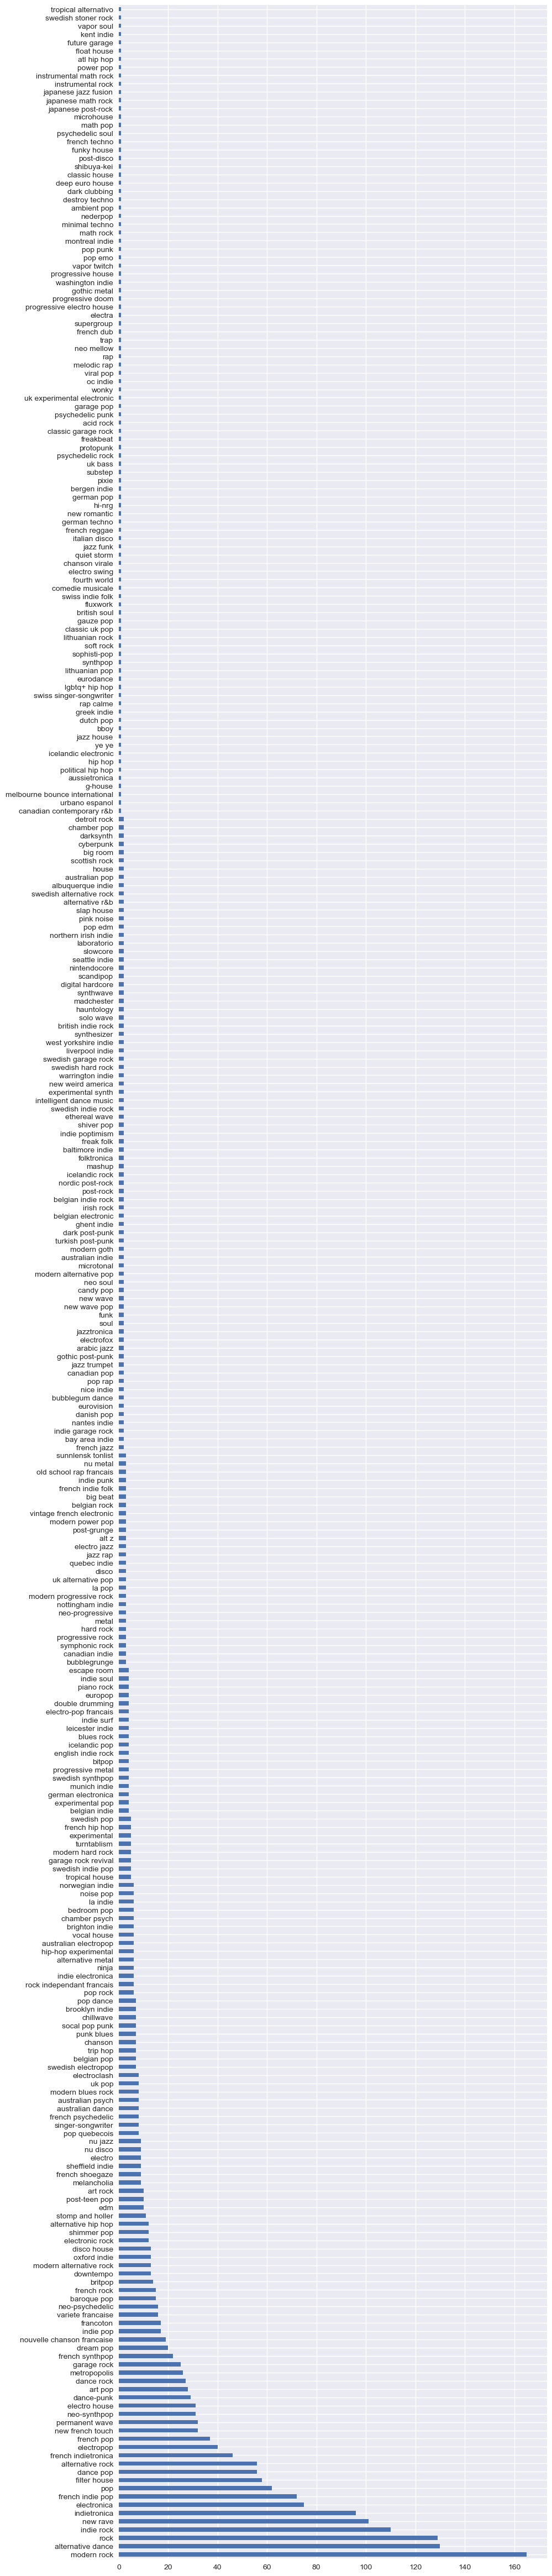

In [500]:
fig = plt.figure()
fig.set_size_inches(10,60)
pd.Series(collected_genre).value_counts().plot.barh()

On retient en genre les suivants :
- jazz ou funk
- pop
- electro ou techno ou club ou tronica
- synth
- rock
- prog ou exp
- alt
- dance, rave
- rap
- ind for indie ou indé (in french)
- franc (français, france), french
- hip hop


In [501]:
selfdefined_genre = ['jazz,funk','pop','electro,tronica','techno,club','house','synth,dream',
'rock','prog,exp','alt,modern','dance,rave','rap','franc, french','ind','hip,hop','metal']
for genre in selfdefined_genre:
    df_playlist[genre] = ''

In [502]:
# identification of the song 49 (50th) to the chosen genres
song = df_playlist.iloc[49]
for genre in selfdefined_genre:
    subgenre = genre.split(',')
    b = False
    for sub in subgenre:
        for song_genre in song['genre']:
            b = b or (sub in song_genre) #we test if in the str of the genre of the song we find an occurence of our subgenre

In [503]:
# identification for every song
for genre in selfdefined_genre:
    rows_in_genre = []
    for song_genre in df_playlist['genre']:
        subgenre = genre.split(',')
        b = False
        for sub in subgenre:
            for song_subgenre in song_genre:
                b = b or (sub in song_subgenre) #we test if in the str of the genre of the song we find an occurence of our subgenre
        rows_in_genre.append(b)
    df_playlist[genre] = rows_in_genre


In [504]:
df_playlist.sample(3)

,id,name,artist,album,release_date,popularity,length,acousticness,danceability,energy,...,"synth,dream",rock,"prog,exp","alt,modern","dance,rave",rap,"franc, french",ind,"hip,hop",metal
516,4IphDJLVgKwLyJ2oBMnFBm,TEA,COBRAH,TEA,2019-07-29,45,167799,0.5110,0.802,0.614,...,False,False,False,True,True,False,False,False,False,False
470,6I9VzXrHxO9rA9A5euc8Ak,Toxic,Britney Spears,In The Zone,2003-11-13,81,198800,0.0249,0.774,0.838,...,False,False,False,False,True,False,False,False,False,False
358,60hb5H9yL4P4SPz7lrTvUw,Intro,Alan Braxe,Running,2000-11-06,51,294720,0.0294,0.859,0.847,...,False,False,False,False,False,False,False,False,False,False


In [505]:
df_playlist.to_pickle("fusion_with_mood_genre_lyrics.pkl")

In [506]:
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

In [507]:
df_playlist.keys()

Index(['id', 'name', 'artist', 'album', 'release_date', 'popularity', 'length',
       'acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'valence', 'loudness', 'speechiness', 'tempo', 'key',
       'time_signature', 'mood', 'genre', 'has_lyrics', 'topics', 'jazz,funk',
       'pop', 'electro,tronica', 'techno,club', 'house', 'synth,dream', 'rock',
       'prog,exp', 'alt,modern', 'dance,rave', 'rap', 'franc, french', 'ind',
       'hip,hop', 'metal'],
      dtype='object')

In [508]:
numvar = ['popularity', 'length',
       'acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'valence', 'loudness', 'speechiness', 'tempo']
categorical_var = ['mood','artist']+selfdefined_genre
list_var = ['genre','topics']
df_clustering = df_playlist[numvar+categorical_var+list_var]
# a question can be ask about popularity


## Numeric Only Clustering

In [282]:
df_clustering[numvar].sample(3)

,popularity,length,acousticness,danceability,energy,instrumentalness,liveness,valence,loudness,speechiness,tempo
660,28,200693,0.00327,0.484,0.903,0.001260,0.106,0.2220,-4.235,0.0803,133.107
533,0,254266,0.38300,0.369,0.396,0.000001,0.115,0.5760,-13.926,0.0668,205.947
366,43,124265,0.98100,0.506,0.259,0.972000,0.528,0.0774,-14.279,0.0349,111.753


c:\Users\leopo\anaconda3\envs\spotify\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\leopo\anaconda3\envs\spotify\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\leopo\anaconda3\envs\spotify\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\leopo\anaconda3\envs\spotify\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarn

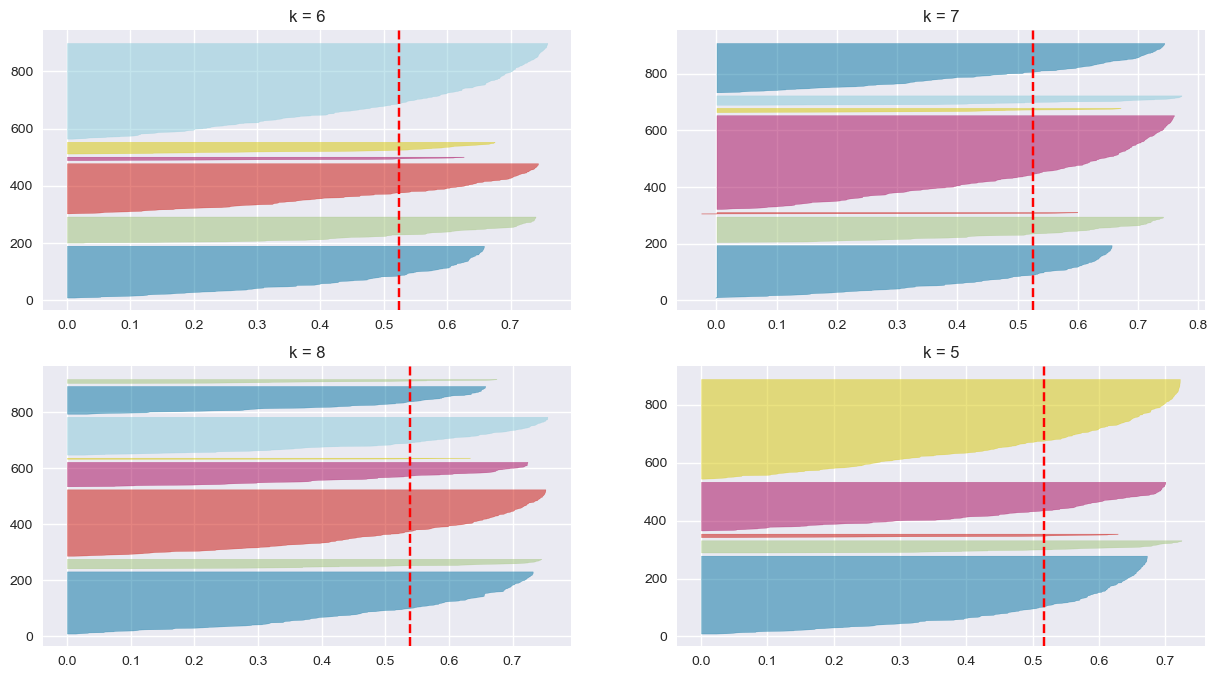

In [283]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(2, 2, figsize=(15,8))
j=0
for i in [5,6,7,8]:#[3, 4, 6, 10]:
    j += 1
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(j, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    ax[q-1][mod].set_title("k = " + str(i))
    visualizer.fit(df_clustering[numvar])


## Numeric and Categorical clustering

Since we made a lot of work to predic a mood and some genre, we must try to use those categorical variables, which we can't do with K-Means.
So first I based the following code on [Jorge Martin Lasaosa post](https://towardsdatascience.com/clustering-on-numerical-and-categorical-features-6e0ebcf1cbad) about Gower Distance, check it out.

Gower distance $ ps_{ij}^{(f)} $ between $i$ and $j$ for the variable $f$ is : 
- for a numeric type : $ ps_{ij}^{(f)} = 1 - |x_{if}-x_{jf}|/R_{f} $ avec $ R_f = \max f - \min f $
- For a categorical feature, the partial similarity between two individuals is one only when both observations have exactly the same value for this feature. Zero otherwise.

Code inspired by this [post](https://www.thinkdatascience.com/post/2019-12-16-introducing-python-package-gower/).

In [509]:
import gower
# we compute this distance explained above


Extension to custom distance matrix :
- if it's a numeric or a categorical feature, use Gower distance
- if it's a list, use Jaccard distance.

Here we are going to use Jaccard distance to measure distance of the brute genres and brutes topics. We also calculate Jaccard distance for a vector of the selected genres.
[Jaccard distance](https://flavien-vidal.medium.com/similarity-distances-for-natural-language-processing-16f63cd5ba55) is defined for a subset A and B (here represented by a list) by :

$d_J(A,B) = 1 - J(A,B)$ where $J(A,B)$ is the Jaccard index defined by :

$J(A,B) = card(A \cap B) / card(A \cup B)$ = proportion of common points

The code is inspired by this [Statology post](https://www.statology.org/jaccard-similarity-python/)

In [510]:
#define Jaccard Similarity function
def jaccard(list1, list2):
    if len(list1+list2) == 0:
        return 1
    else:
        intersection = len(list(set(list1).intersection(list2)))
        union = (len(list1) + len(list2)) - intersection
        return float(intersection) / union       
def jaccard_dissimilarity_matrix(df):
    n = len(df)
    matrix = np.zeros((n,n))
    for i in range(n):
        for j  in range(i):
            d = 1 - jaccard(df.iloc[i],df.iloc[j])
            matrix[i,j] = d
            matrix[j,i] = d
    return matrix

def custom_distance_matrix(df_clustering):
    """the idea is to do an extension of the gower distance with the defined custom distance
    since the final distance matrix is the mean of each dissimilarity matrix we will use the distance matrix to compute for 
    numerical and categorical and compute our own matrix to compute for list var"""
    distance_matrix = gower.gower_matrix(df_clustering[numvar+categorical_var])
    distance_matrix = len(numvar+categorical_var)*distance_matrix
    for var in list_var:
        distance_matrix += jaccard_dissimilarity_matrix(df_clustering[var])
    distance_matrix = distance_matrix/len(numvar+categorical_var+list_var)
    return distance_matrix

In [511]:
distance_matrix = custom_distance_matrix(df_clustering)

In [512]:
(distance_matrix<0).any() or (distance_matrix>1).any()

False

### With clustering DBScan

In [438]:
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import DBSCAN

#km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
dbscan_cluster = DBSCAN(eps=0.11, 
                    min_samples=2, 
                    metric="precomputed")
q, mod = divmod(j, 2)
'''
Create SilhouetteVisualizer instance with KMeans instance
Fit the visualizer
'''
visualizer = SilhouetteVisualizer(dbscan_cluster, colors='yellowbrick', ax=ax[q-1][mod])
ax[q-1][mod].set_title("k = " + str(i))
dbscan_cluster.fit(distance_matrix)


DBSCAN(eps=0.11, metric='precomputed', min_samples=2)

In [439]:
df_clustering["cluster"] = dbscan_cluster.labels_

C:\Users\leopo\AppData\Local\Temp\ipykernel_1072\2529867548.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clustering["cluster"] = dbscan_cluster.labels_


Number of clusters :

(-1 = outliers)

In [440]:
df_clustering['cluster'].nunique()

94

Number of song by cluster

In [441]:
for i in range(-1, df_clustering['cluster'].nunique()):
    print(len(df_clustering[df_clustering['cluster']==i]), end=', ')

371, 7, 24, 18, 12, 2, 3, 10, 2, 32, 19, 2, 2, 18, 2, 2, 17, 3, 6, 2, 2, 3, 2, 3, 5, 2, 7, 10, 2, 2, 3, 2, 12, 3, 2, 5, 3, 4, 4, 2, 3, 4, 2, 2, 2, 2, 4, 3, 2, 2, 3, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 4, 2, 2, 2, 2, 2, 6, 8, 24, 9, 3, 6, 4, 9, 29, 4, 3, 5, 2, 2, 2, 2, 2, 2, 3, 0, 

Mostly a failure : the first cluster is too big, which is coherent, DBScan is made for outliers spotting

###  AffinityPropagation
Trying with another clustering methods : AffinityPropagation. Results are corrects

In [513]:
#from sklearn.cluster import SpectralClustering essayé fonctionne très mal
from sklearn.cluster import AffinityPropagation

Examples : we can set a series of examples

In [514]:
examples_id = ['6z4n862KhNJNWDYSn4aLL5','7uv632EkfwYhXoqf8rhYrg','1GMQEnykhAyTLwkIViTFQk','16tvIGzCNfRLVbm8G39DDo',
'5mY8mY7DSfuqVbY2psq3Cg','6jkN2vp6rSP1WMlPJVlWQB','6TSDRzJGwbK9cajVbtqlPV','56iv5TqfvxVa4zLMs6SvmP','0cx1vZcndRhwSDgR8NtEfk',
'4h33lJL2YU05kEMaSkao47','7Fe3ZwOjTVppElF4TMfxNP','46WOptLnXUtH3LOyYvmMO1','4Ztvl8C9Ld3IdHNo1a3UBe','5N7NLLGdrTy4QYuyM6ewm0','2Y0iGXY6m6immVb2ktbseM',
'3gcmn2CtOE9SjBevmvGVEk','2mcMoXYHmVLxmCgAvaO2cS','3XZssUmtDdhFK1tZJasgXD']

In [517]:
len(examples_id)

18

In [516]:
examples_index = list(df_playlist.loc[df_playlist['id'].isin(examples_id)].index)
preferences = np.zeros(len(df_clustering))
for i in examples_index:
    preferences[i]=1/len(examples_id)

In [519]:
#choosen_model = KMeans(n_clusters=10, init='k-means++', n_init=10, max_iter=2000, random_state=100)# 200,42
choosen_model = AffinityPropagation(damping = 0.5, affinity='precomputed', max_iter=1000,preference=preferences)
# idée assigné des points au musique en fonction de mon nombre d'écoute => voir la doc dans preference

In [520]:
results = choosen_model.fit(distance_matrix)

In [521]:
df_clustering['cluster'] = results.labels_

C:\Users\leopo\AppData\Local\Temp\ipykernel_1072\674743309.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clustering['cluster'] = results.labels_


### Analysing results

Number of clusters : (and in the idea the number of playlist)

In [522]:
df_clustering['cluster'].nunique()

8

How many songs by playlist :

In [523]:
for i in range(10):
    print(f"For the cluster {i}, there are {len(df_clustering[df_clustering['cluster']==i])} songs")


For the cluster 0, there are 26 songs
For the cluster 1, there are 87 songs
For the cluster 2, there are 146 songs
For the cluster 3, there are 26 songs
For the cluster 4, there are 44 songs
For the cluster 5, there are 81 songs
For the cluster 6, there are 112 songs
For the cluster 7, there are 132 songs
For the cluster 8, there are 0 songs
For the cluster 9, there are 0 songs


What kind of characteristics has each cluster : 

In [524]:
df_clustering.groupby('cluster').sum()

C:\Users\leopo\AppData\Local\Temp\ipykernel_1072\1973429802.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_clustering.groupby('cluster').sum()


,popularity,length,acousticness,danceability,energy,instrumentalness,liveness,valence,loudness,speechiness,...,"synth,dream",rock,"prog,exp","alt,modern","dance,rave",rap,"franc, french",ind,"hip,hop",metal
cluster,,,,,,,,,,,,,,,,,,,,,
0,1022,7917274,4.648865,15.477,17.760,13.132740,4.8988,10.2804,-230.810,1.4661,...,2,1,1,1,1,0,10,7,1,0
1,3688,18805819,15.329890,60.473,61.668,9.096052,18.8360,54.3579,-588.974,5.8961,...,16,7,1,9,40,2,20,51,0,1
2,5054,32097519,38.386445,92.101,93.124,17.153746,22.5706,70.1075,-1091.419,12.1765,...,3,5,8,8,4,2,24,11,12,2
3,931,7637084,4.353243,16.936,17.751,12.072810,5.1209,12.7451,-220.873,1.6404,...,2,4,1,1,1,0,4,6,2,0
4,1761,10500129,11.194448,26.994,25.651,1.654152,7.0460,17.5038,-366.477,5.3666,...,7,11,0,1,1,0,14,39,0,0
5,3429,20655703,8.057240,50.991,61.809,17.760683,12.9126,48.9950,-516.440,4.3888,...,23,66,7,67,45,1,1,77,1,0
6,5771,28509611,11.603267,61.482,85.839,15.109553,21.0211,45.9235,-633.386,5.7820,...,22,61,1,75,60,1,1,78,1,0
7,7027,29922503,7.613011,78.663,107.868,7.438676,35.3592,82.4103,-727.435,10.8726,...,1,86,2,107,43,1,7,50,11,7


We can also see for each cluster what is the central track

In [525]:
df_playlist.iloc[results.cluster_centers_indices_]

,id,name,artist,album,release_date,popularity,length,acousticness,danceability,energy,...,"synth,dream",rock,"prog,exp","alt,modern","dance,rave",rap,"franc, french",ind,"hip,hop",metal
111,26JkaeeVVIPLquHEsf7YJd,Summertime Clothes,Animal Collective,Merriweather Post Pavilion,2009-01-10,36,274213,0.001640,0.491,0.871,...,True,True,True,True,True,False,False,True,False,False
186,4m3M6l513rITHvn9LaKJeA,The Final Thing on My Mind,The Pineapple Thief,Your Wilderness,2016-08-12,40,593604,0.015600,0.357,0.497,...,False,True,True,True,False,False,False,False,False,True
320,27MJQKKDik4a8KSPpktTJ0,Lights & Music,Cut Copy,In Ghost Colours,2008-01-01,43,277386,0.073500,0.603,0.946,...,True,True,False,True,True,False,False,True,False,False
340,26JkaeeVVIPLquHEsf7YJd,Summertime Clothes,Animal Collective,Merriweather Post Pavilion,2009-01-10,36,274213,0.001640,0.491,0.871,...,True,True,True,True,True,False,False,True,False,False
354,6PSRMbqr5se9zwl5iOYOA8,Poney Pt. I,Vitalic,OK Cowboy,2005-04-04,41,323000,0.000824,0.580,0.718,...,False,False,False,True,True,False,False,False,False,False
417,7H9csL7dKKKe2YvnuhppGe,Gangster moderne,MC Solaar,Paradisiaque / Mc Solaar,2021-12-03,36,245826,0.066700,0.762,0.575,...,False,False,False,False,False,True,True,False,True,False
418,24PxaqIrZ3cujSNRQDBa6m,Bouge de là - Part. 1,MC Solaar,Bouge de là,1991,41,191466,0.043100,0.814,0.606,...,False,False,False,False,False,True,True,False,True,False
582,4SohcSzXceGEWTwp9Q9vwk,Océan rouge,Flavien Berger,Mars balnéaire,2014-06-23,41,827586,0.522000,0.570,0.258,...,True,False,False,False,False,False,False,True,False,False


In [526]:
nb_playlist = df_clustering['cluster'].nunique()

In [300]:
"""U2FsdGVkX1/Dr36Htbd0NHeSyt7zcwtOQAlJhOZtI448GRilIUDqUXbG2VcrJ3P9vptgDzKVDtdT4Oem
8or4aSpWtATxKVoPB0zFaiDwvO9xGZ3LMmczFu4VdpSm41KwAVd47tUU3rB6GYnBfBbLgglun0vTKlp0
EkSa+Nf8A3paQIcCKVIjvQFD4jUyIdqucqh+De+Q83QfBXsawCoByXTbVrMeA+KClO6eFO5yvh8cc0GS
Xa/ulwOiGLIZR94ZatZNG4HHOHdPnFlJ5VS48olv0FzUV9tXom/9omdtF+Qm2nragQ30nfMQUG4q56Dl
D2bCxpM7LHcqUeyt8rtDCGKvLKm3Op17OJ3mgCDQpRpXFc+fqJCyKXhEglMOJ4g2gox4xvBtCVtPlKsp
9HLO2GKPXO9GsFGmYlGtVkMm1ZqfAR90tWZvfYWNUBI5ZlffvB9VGmsRi4zoM+LyETIhJtEtPOUG0NVO
/I1pVHy20yGBZC4/szf8/NUnbf0Njelz4gc6oppflk2fDeZn5pr5Zl38rL81G/Ev2gmm476UXdE="""

'U2FsdGVkX1/Dr36Htbd0NHeSyt7zcwtOQAlJhOZtI448GRilIUDqUXbG2VcrJ3P9vptgDzKVDtdT4Oem\n8or4aSpWtATxKVoPB0zFaiDwvO9xGZ3LMmczFu4VdpSm41KwAVd47tUU3rB6GYnBfBbLgglun0vTKlp0\nEkSa+Nf8A3paQIcCKVIjvQFD4jUyIdqucqh+De+Q83QfBXsawCoByXTbVrMeA+KClO6eFO5yvh8cc0GS\nXa/ulwOiGLIZR94ZatZNG4HHOHdPnFlJ5VS48olv0FzUV9tXom/9omdtF+Qm2nragQ30nfMQUG4q56Dl\nD2bCxpM7LHcqUeyt8rtDCGKvLKm3Op17OJ3mgCDQpRpXFc+fqJCyKXhEglMOJ4g2gox4xvBtCVtPlKsp\n9HLO2GKPXO9GsFGmYlGtVkMm1ZqfAR90tWZvfYWNUBI5ZlffvB9VGmsRi4zoM+LyETIhJtEtPOUG0NVO\n/I1pVHy20yGBZC4/szf8/NUnbf0Njelz4gc6oppflk2fDeZn5pr5Zl38rL81G/Ev2gmm476UXdE='

In [527]:
#create a dictionary with authorization keys
CREDENTIALS = {}
CREDENTIALS['client_id'] = client_id
CREDENTIALS['client_secret'] = client_secret
CREDENTIALS['redirect_url'] = redirect_url
CREDENTIALS['user_id'] = userid
CREDENTIALS['genius_access_token'] = genius_access_token # genius is optional, only

"""You also can set your credentials id on credentials.py and import from spotiscience"""

# returns 'downloader class'
sd = sps.downloader.SpotiScienceDownloader(credentials=CREDENTIALS)


In [528]:
from importlib import reload

In [529]:
reload(sps.downloader)

<module 'spotiscience.downloader' from 'c:\\Users\\leopo\\OneDrive - GENES\\SpotifyProject\\Examples-playlist-making\\spotiscience-1\\spotiscience\\downloader.py'>

In [530]:
sd = sps.downloader.SpotiScienceDownloader(credentials=CREDENTIALS)

In [531]:
nb_playlist

8

In [533]:
for i in range(nb_playlist):
    song_ids =[]
    for id in df_playlist[df_clustering['cluster']==i]['id']:
        song_ids.append("spotify:track:"+id)
    sd.add_playlist(f"AffinityPropagation Cluster V3 {i}",song_ids)

Creating with scope :  playlist-modify-public the playlist :  AffinityPropagation Cluster V3 0
Creating with scope :  playlist-modify-public the playlist :  AffinityPropagation Cluster V3 1
Creating with scope :  playlist-modify-public the playlist :  AffinityPropagation Cluster V3 2
Creating with scope :  playlist-modify-public the playlist :  AffinityPropagation Cluster V3 3
Creating with scope :  playlist-modify-public the playlist :  AffinityPropagation Cluster V3 4
Creating with scope :  playlist-modify-public the playlist :  AffinityPropagation Cluster V3 5
Creating with scope :  playlist-modify-public the playlist :  AffinityPropagation Cluster V3 6
Creating with scope :  playlist-modify-public the playlist :  AffinityPropagation Cluster V3 7


In [ ]:
# idée d'amélioration possible mettre moins de poids à certaines choses en faisant moi même la moyenne 